### Load Modules and Data

In [40]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose


In [41]:
elec_path='data/eaglei_data/'
storm_path='data/NOAA_StormEvents/'

In [42]:
history = pd.read_csv(elec_path+'coverage_history.csv')
history


,year,state,total_customers,min_covered,max_covered,min_pct_covered,max_pct_covered
0,1/1/18,AK,340543,229424,229424,0.67,0.67
1,1/1/19,AK,340543,217506,229424,0.64,0.67
2,1/1/20,AK,328964,158477,224243,0.48,0.68
3,1/1/21,AK,331443,224243,226079,0.68,0.68
4,1/1/22,AK,364614,226079,258830,0.62,0.71
...,...,...,...,...,...,...,...
275,1/1/18,WY,339370,211190,211190,0.62,0.62
276,1/1/19,WY,339370,199512,229576,0.59,0.68
277,1/1/20,WY,325946,213717,230825,0.66,0.71
278,1/1/21,WY,328728,230825,232248,0.70,0.71


In [12]:
eaglei_2014=pd.read_csv(elec_path+'eaglei_outages_2014.csv')
eaglei_2015=pd.read_csv(elec_path+'eaglei_outages_2015.csv')
eaglei_2016=pd.read_csv(elec_path+'eaglei_outages_2016.csv')
eaglei_2017=pd.read_csv(elec_path+'eaglei_outages_2017.csv')
eaglei_2018=pd.read_csv(elec_path+'eaglei_outages_2018.csv')
eaglei_2019=pd.read_csv(elec_path+'eaglei_outages_2019.csv')
eaglei_2020=pd.read_csv(elec_path+'eaglei_outages_2020.csv')
eaglei_2021=pd.read_csv(elec_path+'eaglei_outages_2021.csv')
eaglei_2022=pd.read_csv(elec_path+'eaglei_outages_2022.csv')
eaglei_2023=pd.read_csv(elec_path+'eaglei_outages_2023.csv')


In [43]:
eaglei_2014=pd.read_csv(elec_path+'eaglei_outages_2014.csv')
eaglei_2014

,fips_code,county,state,customers_out,run_start_time
0,1037,Coosa,Alabama,12,2014-11-01 04:00:00
1,1051,Elmore,Alabama,7,2014-11-01 04:00:00
2,1109,Pike,Alabama,1,2014-11-01 04:00:00
3,1121,Talladega,Alabama,31,2014-11-01 04:00:00
4,4017,Navajo,Arizona,1,2014-11-01 04:00:00
...,...,...,...,...,...
1689455,55029,Door,Wisconsin,1,2014-12-31 00:00:00
1689456,55079,Milwaukee,Wisconsin,1,2014-12-31 00:00:00
1689457,55093,Pierce,Wisconsin,6,2014-12-31 00:00:00
1689458,55125,Vilas,Wisconsin,6,2014-12-31 00:00:00


### Merging data 

In [44]:
def create_daily_aggregated_df(years):
    """
    Function to aggregate customers_out by day for each year and concatenate the results.
    
    Parameters:
    years (list): List of years to process (e.g., [2014, 2015, ..., 2023])
    
    Returns:
    pd.DataFrame: Concatenated DataFrame with daily aggregated customers_out for all years
    """
    # List to store each year's aggregated DataFrame
    dfs = []
    
    # Process each year
    for year in years:
        print(f"Processing year {year}...")
        
        # Step 1: Load the data for the year
        file_path = f'eaglei_outages_{year}.csv'
        try:
            df = pd.read_csv(elec_path+file_path)
        except FileNotFoundError:
            print(f"File for year {year} not found. Skipping...")
            continue
        
        # Step 2: Convert run_start_time to datetime
        df['run_start_time'] = pd.to_datetime(df['run_start_time'])
        
        # Step 3: Set run_start_time as the index for resampling
        df.set_index('run_start_time', inplace=True)
        
        # Step 4: Resample by day and sum customers_out
        df_daily = df['customers_out'].resample('D').sum().reset_index()
        
        # Step 5: Add a 'year' column to identify the year
        df_daily['year'] = year
        
        # Append the resampled DataFrame to the list
        dfs.append(df_daily)
    
    # Step 6: Concatenate all DataFrames
    if not dfs:
        raise ValueError("No data was processed. Check if the files exist.")
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Step 7: Rename columns for clarity
    combined_df.columns = ['date', 'customers_out', 'year']
    
    return combined_df

# Example usage:
years = range(2014, 2024)  # Years 2014 to 2023
daily_aggregated_df = create_daily_aggregated_df(years)

Processing year 2014...
Processing year 2015...
Processing year 2016...
Processing year 2017...
Processing year 2018...
Processing year 2019...
Processing year 2020...
Processing year 2021...
Processing year 2022...
Processing year 2023...


### Graphs of customers_out vs date 

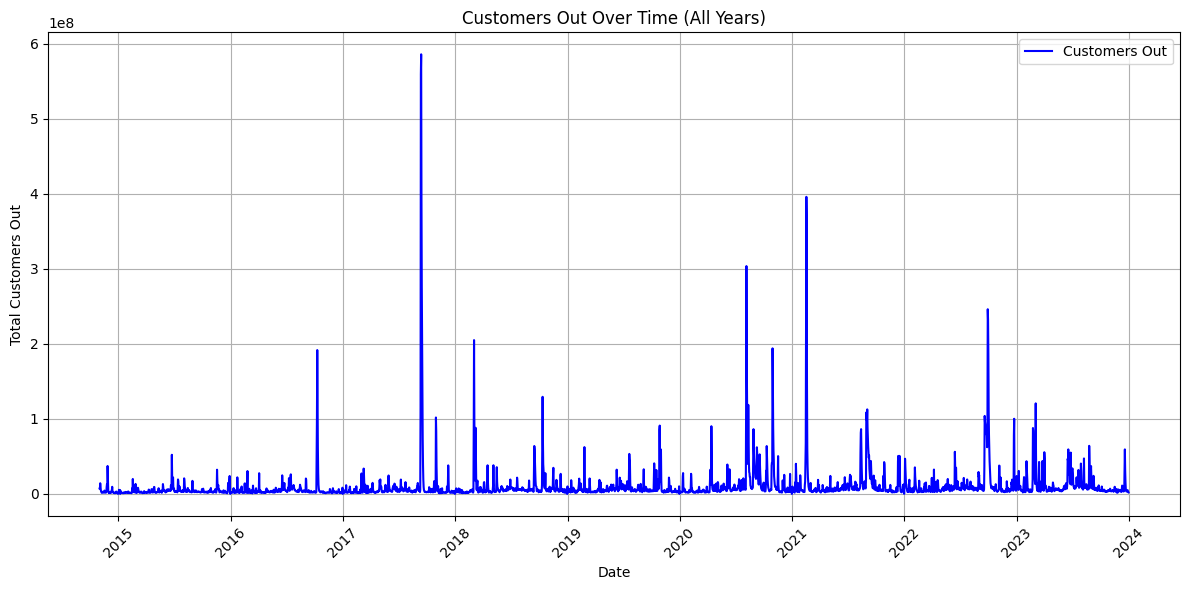

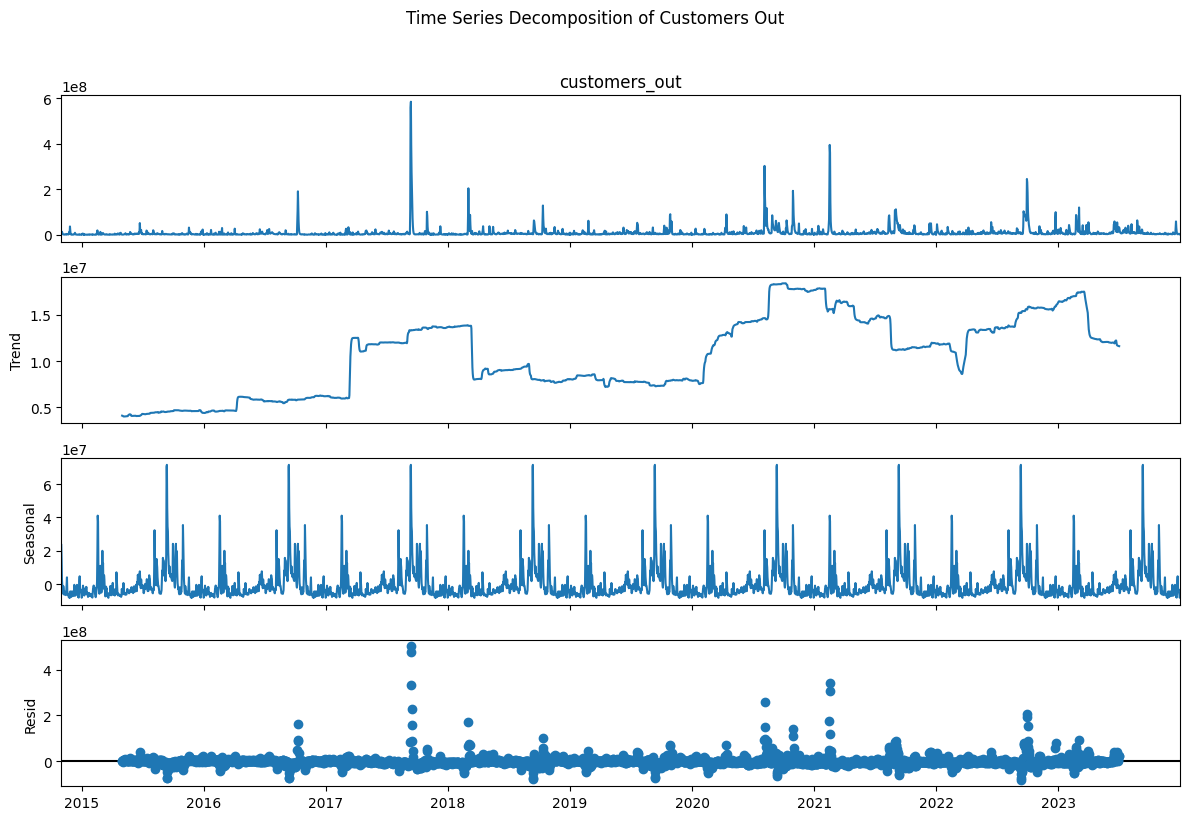

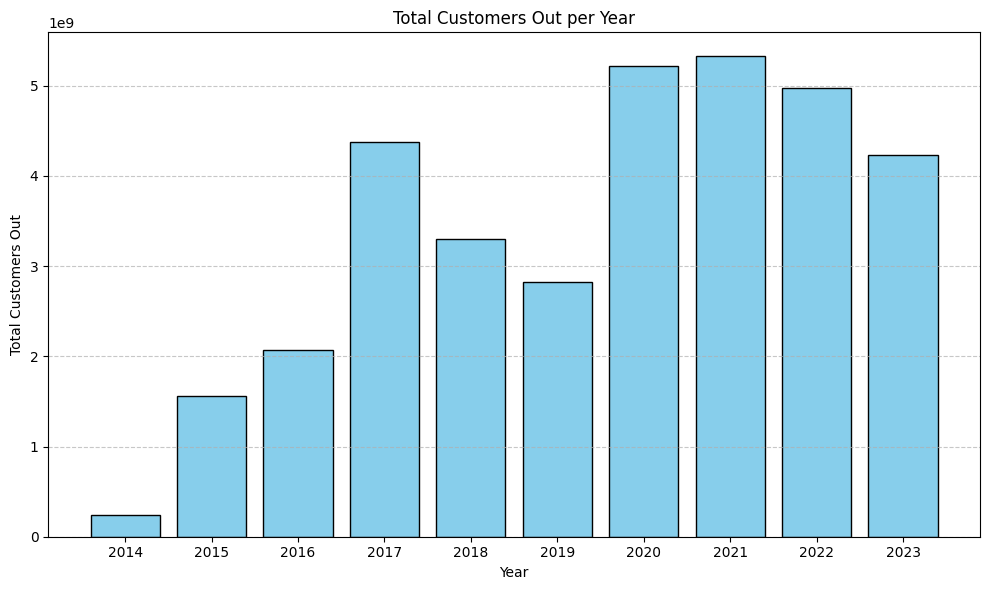

In [27]:

# Assuming daily_aggregated_df is already created from the previous function
# For demonstration, let's assume daily_aggregated_df exists with columns: date, customers_out, year

# Plot 1: Line Plot of customers_out vs date (all years combined)
plt.figure(figsize=(12, 6))
plt.plot(daily_aggregated_df['date'], daily_aggregated_df['customers_out'], label='Customers Out', color='blue')
plt.title('Customers Out Over Time (All Years)')
plt.xlabel('Date')
plt.ylabel('Total Customers Out')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Time Series Decomposition Plot
# Prepare the data for decomposition (needs a datetime index)
decomp_df = daily_aggregated_df.set_index('date')['customers_out']

# Perform decomposition (assuming a yearly seasonality, period=365 days)
decomposition = seasonal_decompose(decomp_df, model='additive', period=365)

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Time Series Decomposition of Customers Out', y=1.02)
plt.tight_layout()
plt.show()

# Plot 3: Yearly Summary Plot (Subplots for each year)
yearly_sum = daily_aggregated_df.groupby('year')['customers_out'].sum().reset_index()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(yearly_sum['year'], yearly_sum['customers_out'], color='skyblue', edgecolor='black')
plt.title('Total Customers Out per Year')
plt.xlabel('Year')
plt.ylabel('Total Customers Out')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(yearly_sum['year'])  # Ensure all years are shown on the x-axis
plt.tight_layout()
plt.show()


### Some Data Processing

In [ ]:
csv_files = glob.glob(storm_path + "StormEvents_details-*.csv")
df_list = [pd.read_csv(file) for file in csv_files]
storms_df = pd.concat(df_list, ignore_index=True)
storms_df

In [47]:
storms_df['BEGIN_DATE_TIME'] = pd.to_datetime(storms_df['BEGIN_DATE_TIME'])
storms_df['storm_date'] = storms_df['BEGIN_DATE_TIME'].dt.date  # Extract date part (e.g., 2014-11-01)

# Ensure daily_aggregated_df['date'] is in datetime.date format for merging
daily_aggregated_df['date'] = pd.to_datetime(daily_aggregated_df['date']).dt.date

# Step 3: Merge the DataFrames on the date column
# Left merge: keep all rows from daily_aggregated_df, and match storm events where possible
merged_df = pd.merge(
    daily_aggregated_df,
    storms_df,
    left_on='date',
    right_on='storm_date',
    how='left'
)

# Step 4: Drop the temporary storm_date column (optional, if you don't need it)
merged_df = merged_df.drop(columns=['storm_date'], errors='ignore')



/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_51179/859669920.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  storms_df['BEGIN_DATE_TIME'] = pd.to_datetime(storms_df['BEGIN_DATE_TIME'])


In [ ]:

time_geo_columns = [
    'BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH', 'END_DAY', 'END_TIME',
    'BEGIN_DATE_TIME', 'END_DATE_TIME', 'CZ_TIMEZONE', 'YEAR', 'MONTH_NAME',
    'STATE', 'STATE_FIPS', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'WFO',
    'TOR_OTHER_CZ_STATE', 'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME',
    'BEGIN_RANGE', 'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH', 'END_LOCATION',
    'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON','DATA_SOURCE',
]

# 去除时间和地理列
merged_df_cleaned = merged_df.drop(columns=time_geo_columns, errors='ignore')
merged_df_cleaned

In [49]:
merged_df_cleaned.to_csv('feature_engineering/Date_feature.csv', index=False)

### Storm Types and Customers out

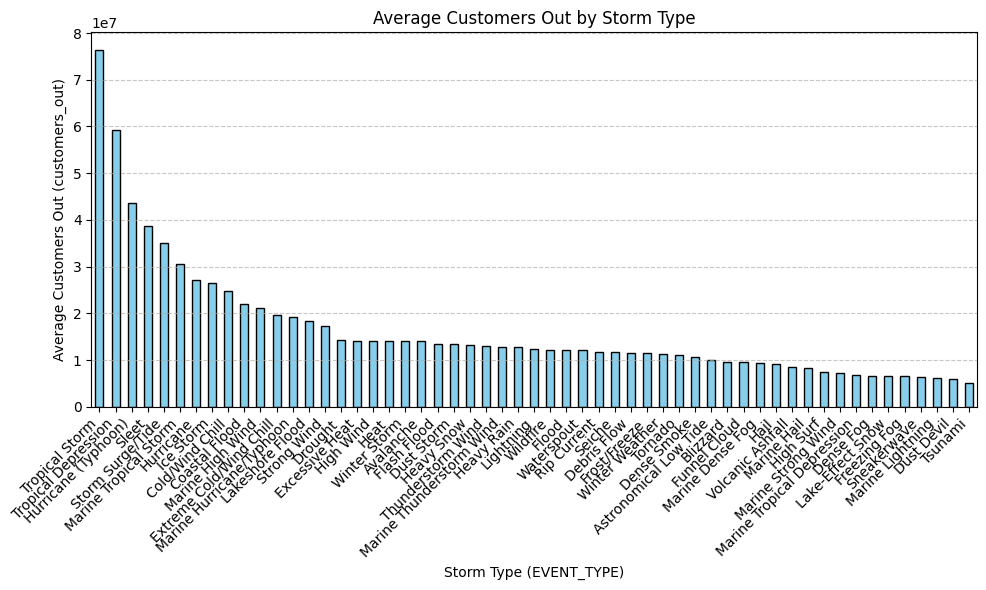

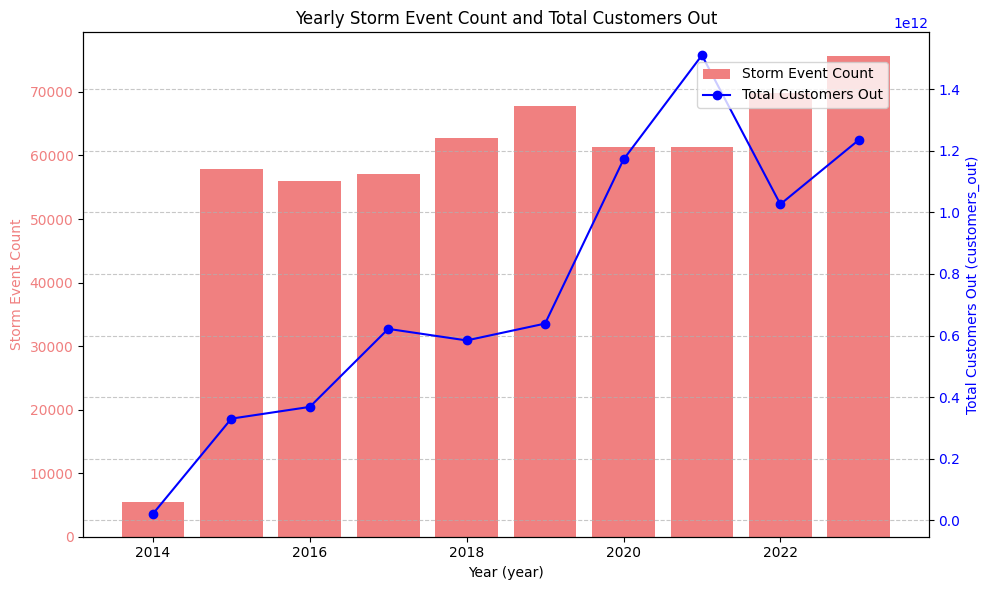

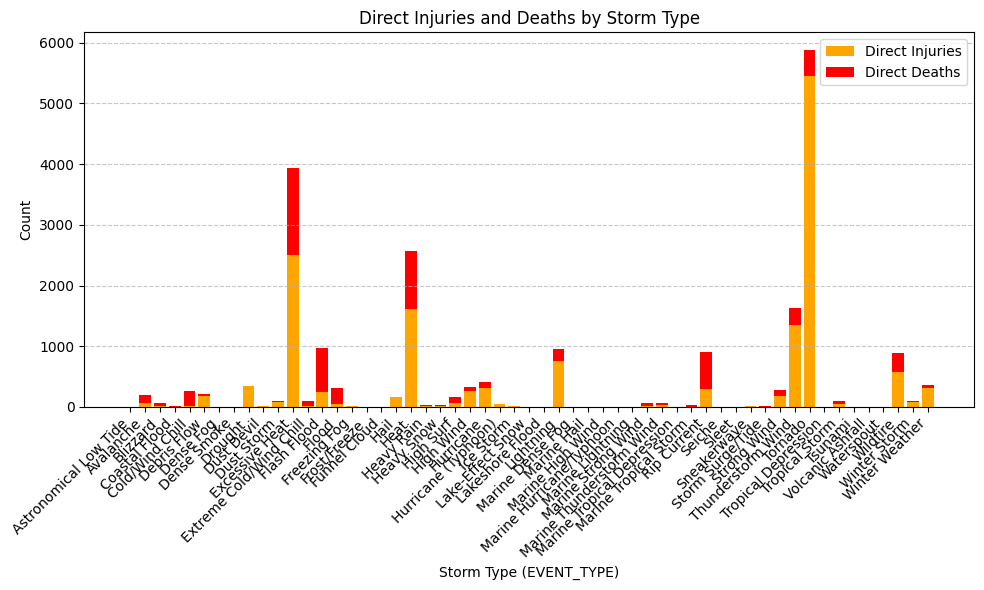

Columns in merged_df_cleaned: ['date', 'customers_out', 'year', 'EPISODE_ID', 'EVENT_ID', 'EVENT_TYPE', 'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE', 'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE', 'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'EPISODE_NARRATIVE', 'EVENT_NARRATIVE']


In [41]:


# Visualization 1: Bar Chart of Average customers_out by EVENT_TYPE
event_type_avg = merged_df_cleaned.groupby('EVENT_TYPE')['customers_out'].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
event_type_avg.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Customers Out by Storm Type')
plt.xlabel('Storm Type (EVENT_TYPE)')
plt.ylabel('Average Customers Out (customers_out)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualization 2: Dual-Axis Plot of Yearly Storm Event Count and Total customers_out
yearly_stats = merged_df_cleaned.groupby('year').agg({
    'EVENT_ID': 'count',  # Count of storm events
    'customers_out': 'sum'  # Total customers out
}).reset_index()
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(yearly_stats['year'], yearly_stats['EVENT_ID'], color='lightcoral', label='Storm Event Count')
ax1.set_xlabel('Year (year)')
ax1.set_ylabel('Storm Event Count', color='lightcoral')
ax1.tick_params(axis='y', labelcolor='lightcoral')
ax2 = ax1.twinx()
ax2.plot(yearly_stats['year'], yearly_stats['customers_out'], color='blue', marker='o', label='Total Customers Out')
ax2.set_ylabel('Total Customers Out (customers_out)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.title('Yearly Storm Event Count and Total Customers Out')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Visualization 4: Stacked Bar Chart of INJURIES_DIRECT and DEATHS_DIRECT by EVENT_TYPE
injury_stats = merged_df_cleaned.groupby('EVENT_TYPE').agg({
    'INJURIES_DIRECT': 'sum',
    'DEATHS_DIRECT': 'sum'
}).reset_index()
plt.figure(figsize=(10, 6))
plt.bar(injury_stats['EVENT_TYPE'], injury_stats['INJURIES_DIRECT'], label='Direct Injuries', color='orange')
plt.bar(injury_stats['EVENT_TYPE'], injury_stats['DEATHS_DIRECT'], bottom=injury_stats['INJURIES_DIRECT'], label='Direct Deaths', color='red')
plt.title('Direct Injuries and Deaths by Storm Type')
plt.xlabel('Storm Type (EVENT_TYPE)')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Print the columns of the cleaned DataFrame for reference
print("Columns in merged_df_cleaned:", merged_df_cleaned.columns.tolist())

### Seasonal Trend and Monthly Trend

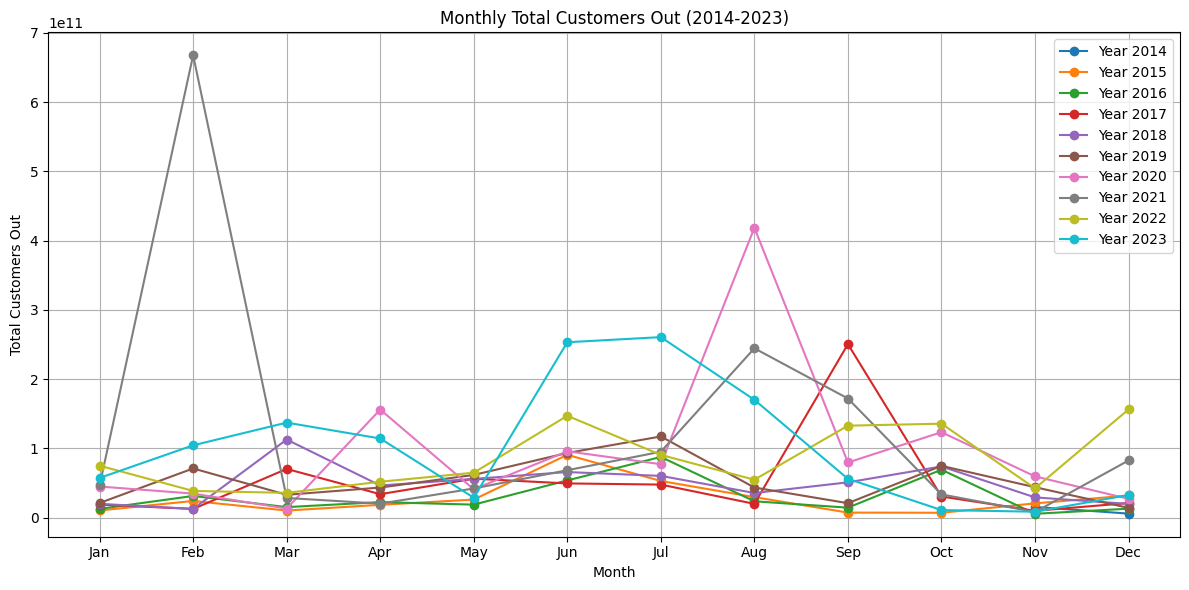

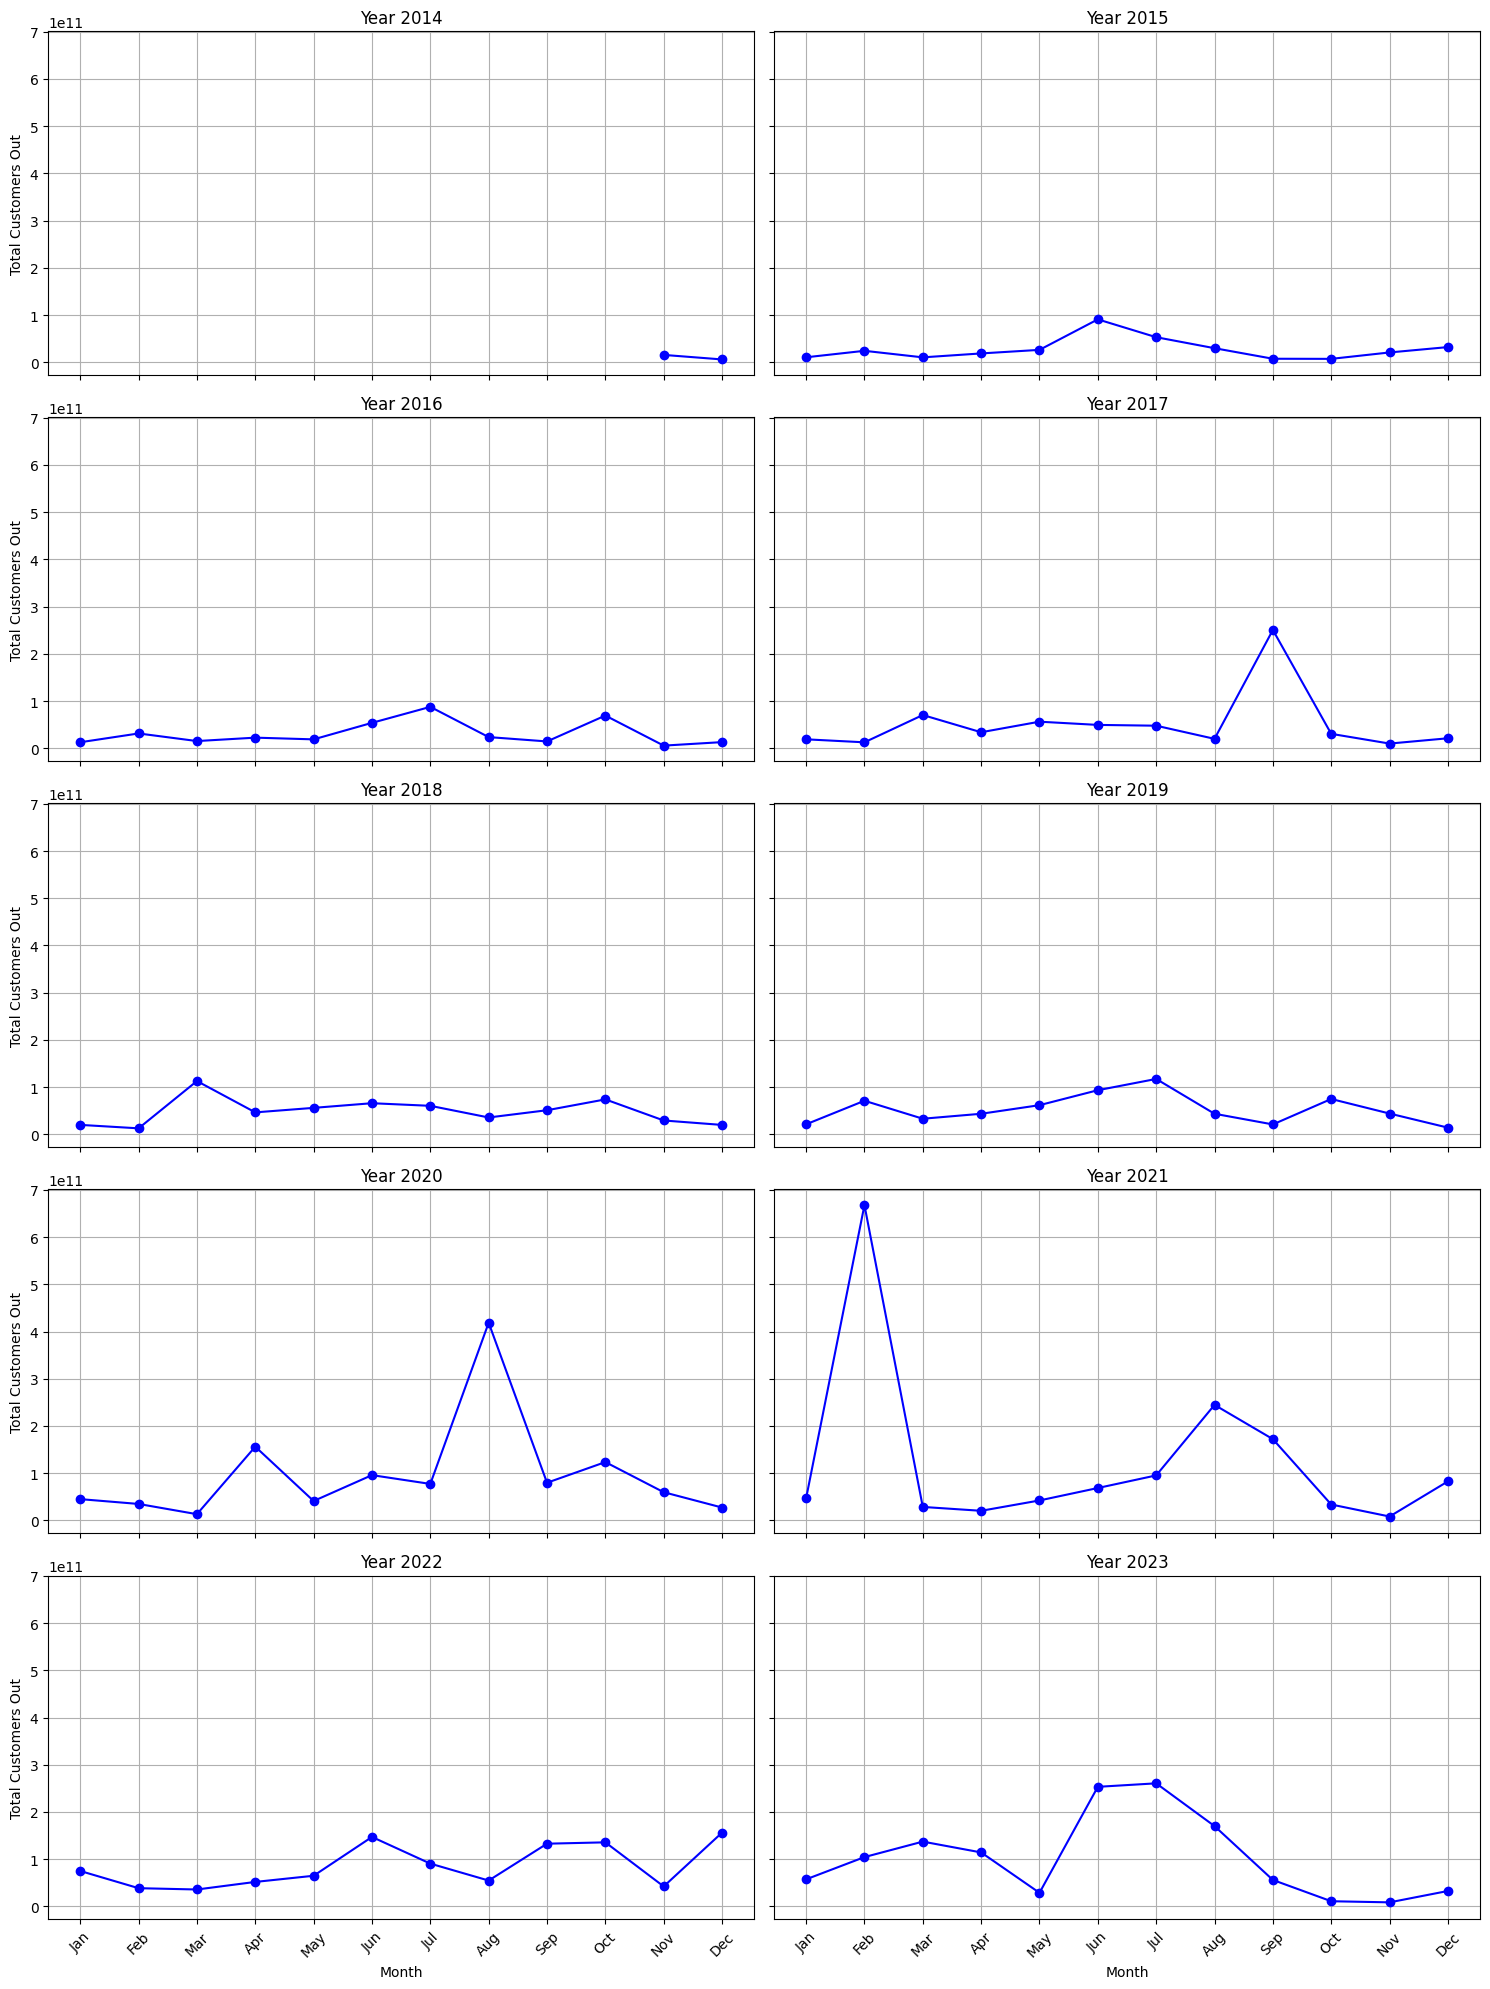

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming merged_df is already created from previous steps
# It contains columns: date, customers_out, year, EVENT_TYPE, DAMAGE_PROPERTY, etc.

# Step 1: Prepare the data
# Extract month from date
merged_df['month'] = pd.to_datetime(merged_df['date']).dt.month

# Step 2: Figure 1 - Single Plot with All Years
plt.figure(figsize=(12, 6))
years = range(2014, 2024)
colors = sns.color_palette("tab10", len(years))  # Generate 10 distinct colors

for i, year in enumerate(years):
    year_data = merged_df[merged_df['year'] == year]
    if year_data.empty:
        continue
    monthly_customers_out = year_data.groupby('month')['customers_out'].sum()
    plt.plot(monthly_customers_out.index, monthly_customers_out.values, marker='o', color=colors[i], label=f'Year {year}')

plt.title('Monthly Total Customers Out (2014-2023)')
plt.xlabel('Month')
plt.ylabel('Total Customers Out')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step 3: Figure 2 - 5x2 Subplots for Each Year
fig, axes = plt.subplots(5, 2, figsize=(15, 20), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten the 5x2 array for easier indexing

for i, year in enumerate(years):
    year_data = merged_df[merged_df['year'] == year]
    if year_data.empty:
        axes[i].set_title(f'Year {year}: No Data')
        continue
    monthly_customers_out = year_data.groupby('month')['customers_out'].sum()
    axes[i].plot(monthly_customers_out.index, monthly_customers_out.values, marker='o', color='blue')
    axes[i].set_title(f'Year {year}')
    axes[i].grid(True)

# Set labels for the bottom row and leftmost column
for ax in axes[-2:]:  # Bottom row
    ax.set_xlabel('Month')
for ax in axes[::2]:  # Leftmost column
    ax.set_ylabel('Total Customers Out')

# Set x-ticks to month names
for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)

plt.tight_layout()
plt.show()

### Other Visualizations that doesn't make sense

In [27]:
import pandas as pd

def combine_outages_by_year(elec_path, start_year=2014, end_year=2023):
    """
    Combines outage data from multiple years into a single DataFrame.
    
    Parameters:
    - elec_path (str): Path to the directory containing the CSV files.
    - start_year (int): Starting year (default: 2014).
    - end_year (int): Ending year (default: 2023).
    
    Returns:
    - pd.DataFrame: A DataFrame with columns fips_code, county, state, customers_out (summed), and year.
    """
    # List to store each year's grouped DataFrame
    all_years_dfs = []
    
    # Loop through each year from start_year to end_year
    for year in range(start_year, end_year + 1):
        try:
            # Construct the file path
            file_path = elec_path + f'eaglei_outages_{year}.csv'
            
            # Read the CSV
            df = pd.read_csv(file_path)
            
            # Group by fips_code, county, state and sum customers_out
            grouped_df = df.groupby(['fips_code', 'county', 'state'], as_index=False)['customers_out'].sum()
            
            # Add a column for the year
            grouped_df['year'] = year
            
            # Append to the list
            all_years_dfs.append(grouped_df)
            
            print(f"Processed data for year {year}")
            
        except FileNotFoundError:
            print(f"File for year {year} not found: {file_path}")
            continue
        except Exception as e:
            print(f"Error processing year {year}: {str(e)}")
            continue
    
    # Check if any data was processed
    if not all_years_dfs:
        raise ValueError("No data was processed. Please check the file paths and data availability.")
    
    # Concatenate all DataFrames vertically
    final_df = pd.concat(all_years_dfs, ignore_index=True)
    
    return final_df

elec_geog_df = combine_outages_by_year(elec_path)
elec_geog_df

# result_df.to_csv('combined_outages_2014_2023.csv', index=False)

Processed data for year 2014
Processed data for year 2015
Processed data for year 2016
Processed data for year 2017
Processed data for year 2018
Processed data for year 2019
Processed data for year 2020
Processed data for year 2021
Processed data for year 2022
Processed data for year 2023


,fips_code,county,state,customers_out,year
0,1001,Autauga,Alabama,5964.0,2014
1,1003,Baldwin,Alabama,27125.0,2014
2,1007,Bibb,Alabama,616.0,2014
3,1011,Bullock,Alabama,29.0,2014
4,1013,Butler,Alabama,8241.0,2014
...,...,...,...,...,...
28089,72113,Ponce,Puerto Rico,28803387.0,2023
28090,72127,San Juan,Puerto Rico,47056130.0,2023
28091,78010,St. Croix,United States Virgin Islands,4022051.0,2023
28092,78020,St. John,United States Virgin Islands,788166.0,2023


In [22]:
storms_df[ [
        'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
        'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'CATEGORY', 'TOR_LENGTH', 'TOR_WIDTH'
    ]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691434 entries, 0 to 691433
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   INJURIES_DIRECT    691434 non-null  int64  
 1   INJURIES_INDIRECT  691434 non-null  int64  
 2   DEATHS_DIRECT      691434 non-null  int64  
 3   DEATHS_INDIRECT    691434 non-null  int64  
 4   DAMAGE_PROPERTY    550448 non-null  object 
 5   DAMAGE_CROPS       552275 non-null  object 
 6   MAGNITUDE          360316 non-null  float64
 7   CATEGORY           369 non-null     float64
 8   TOR_LENGTH         15641 non-null   float64
 9   TOR_WIDTH          15641 non-null   float64
dtypes: float64(4), int64(4), object(2)
memory usage: 52.8+ MB


In [ ]:
import pandas as pd
import numpy as np

def parse_damage(value):
    """
    解析 DAMAGE_PROPERTY 和 DAMAGE_CROPS 列，将字符串转换为数值（单位：美元）。
    
    参数：
    - value: 输入值，可能是字符串（如 "15.00K" 或 "1.5M"）或 NaN
    
    返回：
    - float: 转换后的数值（单位：美元），如果是 NaN 则返回 NaN
    """
    if pd.isna(value):  # 处理 NaN 值
        return np.nan
    if isinstance(value, str):
        value = value.upper()
        if 'K' in value:
            return float(value.replace('K', '')) * 1000
        elif 'M' in value:
            return float(value.replace('M', '')) * 1000000
        elif 'B' in value:
            return float(value.replace('B', '')) * 1000000000
        else:
            return float(value)
    return float(value)

def group_storms_by_year_region_month(storms_df):
    """
    按照年份、地区和开始月份分组，计算指定列的平均值，并丢弃其他列。
    特别处理 DAMAGE_PROPERTY 和 DAMAGE_CROPS 列，将字符串转换为数值并取整。
    
    参数：
    - storms_df (pd.DataFrame): 包含风暴数据的 DataFrame
    
    返回：
    - pd.DataFrame: 包含分组后的年份、地区、开始月份和指定列平均值的 DataFrame
    """
    # 步骤 1：提取开始月份
    storms_df['BEGIN_MONTH'] = storms_df['BEGIN_YEARMONTH'] % 100
    
    # 步骤 2：处理 DAMAGE_PROPERTY 和 DAMAGE_CROPS
    storms_df['DAMAGE_PROPERTY'] = storms_df['DAMAGE_PROPERTY'].apply(parse_damage)
    storms_df['DAMAGE_CROPS'] = storms_df['DAMAGE_CROPS'].apply(parse_damage)
    
    # 步骤 3：定义分组列和需要计算平均值的列
    group_cols = ['YEAR', 'STATE_FIPS', 'BEGIN_MONTH']
    avg_cols = [
        'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
        'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'CATEGORY', 'TOR_LENGTH', 'TOR_WIDTH'
    ]
    
    # 步骤 4：选择相关列并分组计算平均值
    selected_df = storms_df[group_cols + avg_cols]
    grouped_df = selected_df.groupby(group_cols, as_index=False).mean()
    
    # 步骤 5：将平均值四舍五入为整数
    for col in avg_cols:
        grouped_df[col] = grouped_df[col].round().astype('Int64')  # 使用 Int64 类型以支持 NaN
    
    # 可选：将 NaN 替换为 0（如果需要）
    # grouped_df = grouped_df.fillna(0)
    
    return grouped_df

# 示例用法：
# storms_df = pd.read_csv('your_storms_data.csv')  # 替换为你的实际数据加载
storm_geog_df = group_storms_by_year_region_month(storms_df)
storm_geog_df
# result_df.to_csv('grouped_storms_by_year_region_month.csv', index=False)

In [ ]:
# 步骤 1：从 elec_geog_df 的 fips_code 中提取州级 FIPS 代码
elec_geog_df['state_fips'] = elec_geog_df['fips_code'].astype(str).str.zfill(5).str[:2].astype(int)

# 步骤 2：汇总 storm_geog_df 按 YEAR 和 STATE_FIPS，计算平均值
storm_geog_annual = storm_geog_df.groupby(['YEAR', 'STATE_FIPS'], as_index=False).mean()

# 删除 BEGIN_MONTH 列（因为我们已经按年份汇总）
storm_geog_annual = storm_geog_annual.drop(columns=['BEGIN_MONTH'])

# 步骤 3：合并两个 DataFrame
merged_df = pd.merge(
    storm_geog_annual,
    elec_geog_df,
    left_on=['YEAR', 'STATE_FIPS'],
    right_on=['year', 'state_fips'],
    how='inner'  # 使用 inner 合并，只保留匹配的记录
)

# 步骤 4：清理合并后的 DataFrame
# 删除冗余列（year 和 state_fips）
merged_df = merged_df.drop(columns=['year', 'state_fips'])

# 可选：重新排序列（根据需要）
final_columns = [
    'YEAR', 'STATE_FIPS', 'state', 'county', 'fips_code',
    'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'CATEGORY', 'TOR_LENGTH', 'TOR_WIDTH',
    'customers_out'
]
merged_df = merged_df[final_columns]
merged_df

,YEAR,STATE_FIPS,state,county,fips_code,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,MAGNITUDE,CATEGORY,TOR_LENGTH,TOR_WIDTH,customers_out
0,2014,1,Alabama,Autauga,1001,0.0,0.0,0.0,0.0,27992.916667,0.0,43.75,<NA>,3.833333,245.5,5964.0
1,2014,1,Alabama,Baldwin,1003,0.0,0.0,0.0,0.0,27992.916667,0.0,43.75,<NA>,3.833333,245.5,27125.0
2,2014,1,Alabama,Bibb,1007,0.0,0.0,0.0,0.0,27992.916667,0.0,43.75,<NA>,3.833333,245.5,616.0
3,2014,1,Alabama,Bullock,1011,0.0,0.0,0.0,0.0,27992.916667,0.0,43.75,<NA>,3.833333,245.5,29.0
4,2014,1,Alabama,Butler,1013,0.0,0.0,0.0,0.0,27992.916667,0.0,43.75,<NA>,3.833333,245.5,8241.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28054,2023,56,Wyoming,Sweetwater,56037,0.0,0.0,0.0,0.0,15149.5,0.0,40.333333,<NA>,3.0,162.0,160442.0
28055,2023,56,Wyoming,Teton,56039,0.0,0.0,0.0,0.0,15149.5,0.0,40.333333,<NA>,3.0,162.0,32497.0
28056,2023,56,Wyoming,Uinta,56041,0.0,0.0,0.0,0.0,15149.5,0.0,40.333333,<NA>,3.0,162.0,47309.0
28057,2023,56,Wyoming,Washakie,56043,0.0,0.0,0.0,0.0,15149.5,0.0,40.333333,<NA>,3.0,162.0,4601.0


In [50]:
merged_df.to_csv('feature_engineering/Grography_features.csv', index=False)

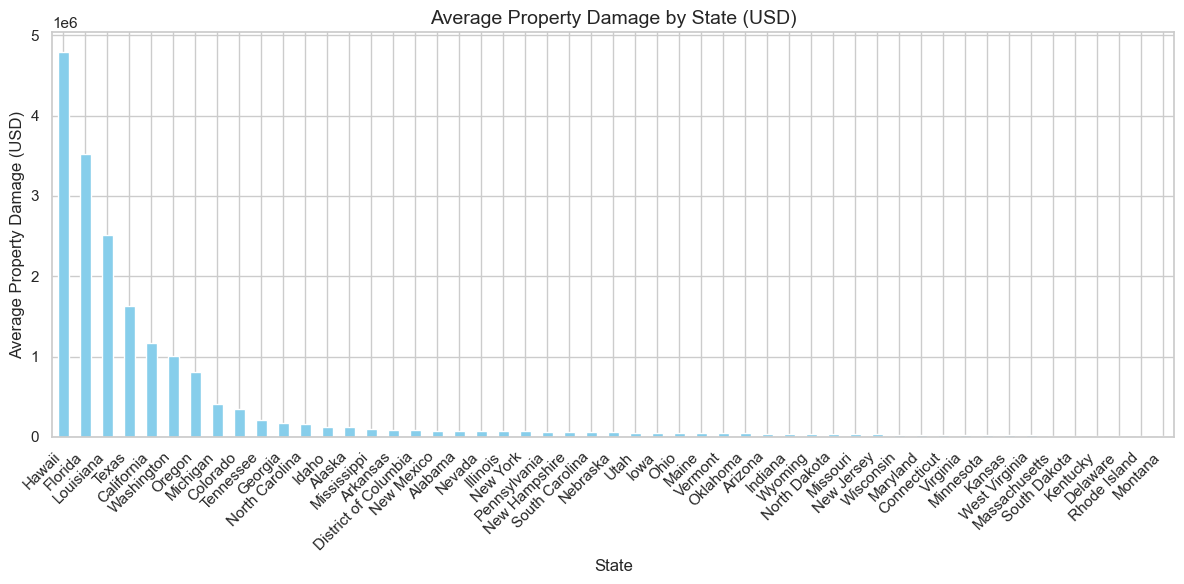

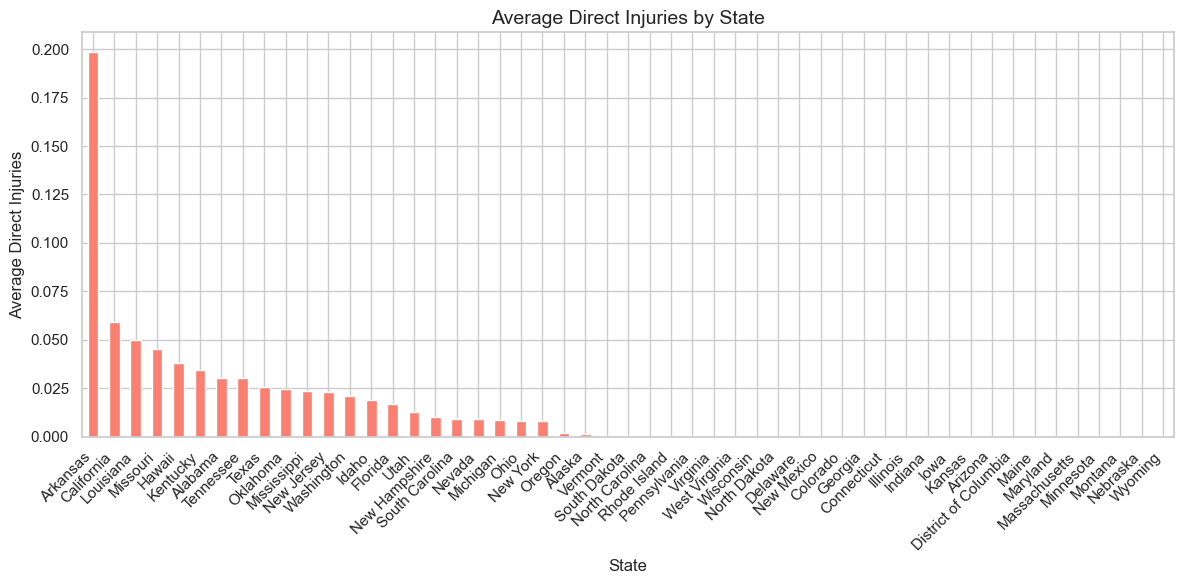

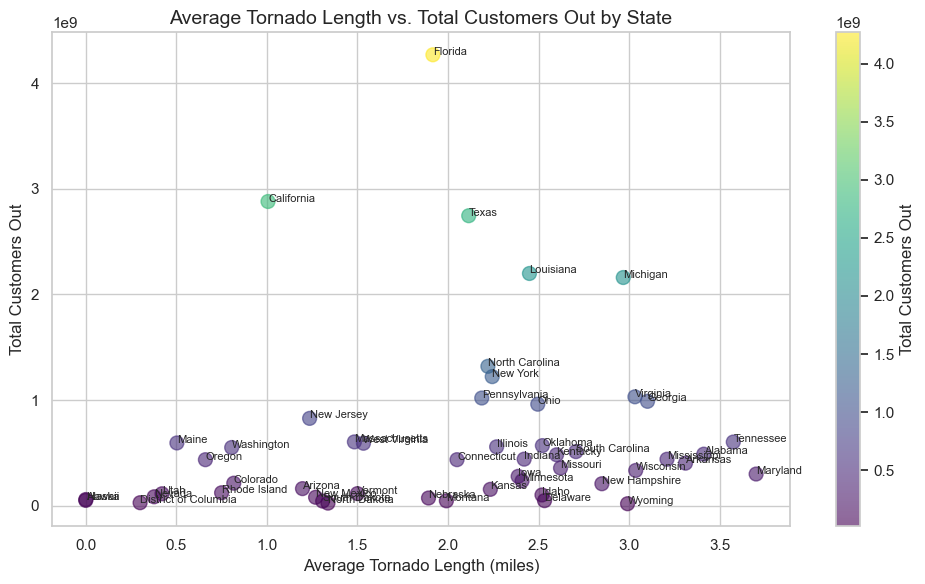

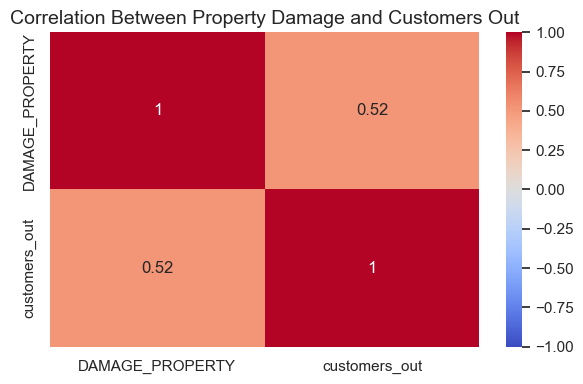

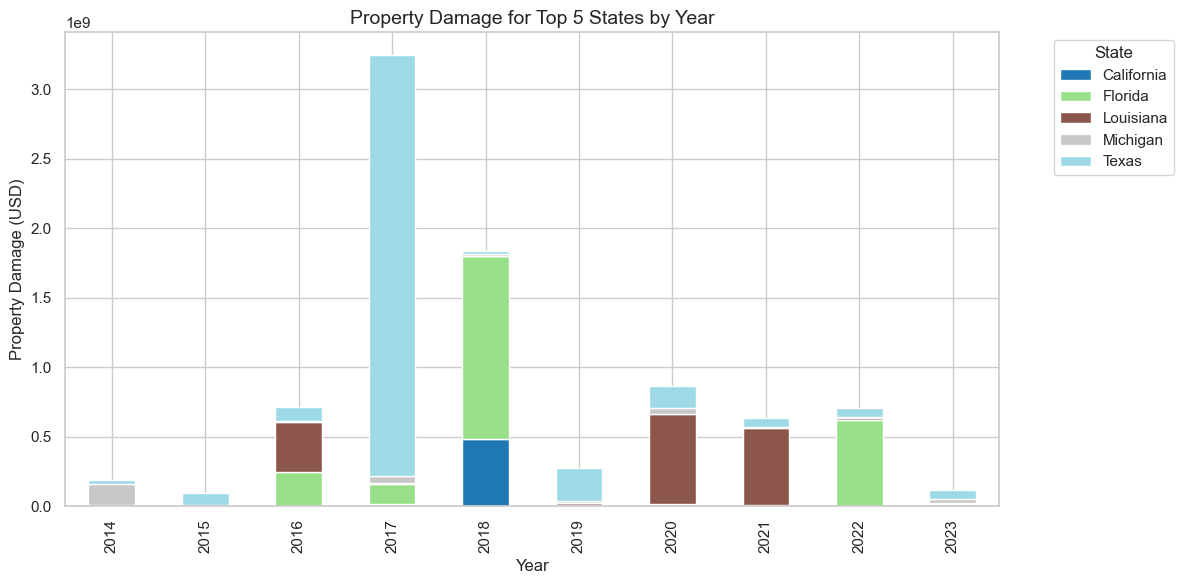

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create a copy of merged_df to avoid modifying the original
plot_df = merged_df.copy()

# Replace NA with 0 in numerical columns to avoid TypeError
numerical_cols = [
    'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'MAGNITUDE', 'CATEGORY', 'TOR_LENGTH', 
    'TOR_WIDTH', 'customers_out'
]
plot_df[numerical_cols] = plot_df[numerical_cols].fillna(0)

# Visualization 1: Bar chart of average property damage by state
state_damage = plot_df.groupby('state')['DAMAGE_PROPERTY'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
state_damage.plot(kind='bar', color='skyblue')
plt.title('Average Property Damage by State (USD)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Property Damage (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Visualization 3: Bar chart of average direct injuries by state
state_injuries = plot_df.groupby('state')['INJURIES_DIRECT'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
state_injuries.plot(kind='bar', color='salmon')
plt.title('Average Direct Injuries by State', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Average Direct Injuries', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 4: Scatter plot of average tornado length vs. total customers out by state
state_tornado = plot_df.groupby('state').agg({
    'TOR_LENGTH': 'mean',
    'customers_out': 'sum'
}).reset_index()
plt.figure(figsize=(10, 6))
plt.scatter(state_tornado['TOR_LENGTH'], state_tornado['customers_out'], 
            s=100, c=state_tornado['customers_out'], cmap='viridis', alpha=0.6)
plt.colorbar(label='Total Customers Out')
plt.title('Average Tornado Length vs. Total Customers Out by State', fontsize=14)
plt.xlabel('Average Tornado Length (miles)', fontsize=12)
plt.ylabel('Total Customers Out', fontsize=12)
for i, state in enumerate(state_tornado['state']):
    plt.annotate(state, (state_tornado['TOR_LENGTH'][i], state_tornado['customers_out'][i]), fontsize=8)
plt.tight_layout()
plt.show()

# Visualization 5: Correlation heatmap of property damage and customers out
state_summary = plot_df.groupby('state').agg({
    'DAMAGE_PROPERTY': 'mean',
    'customers_out': 'sum'
}).reset_index()
corr_matrix = state_summary[['DAMAGE_PROPERTY', 'customers_out']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Between Property Damage and Customers Out', fontsize=14)
plt.tight_layout()
plt.show()

# Visualization 6: Stacked bar chart of property damage for top 5 states by year
top_states = plot_df.groupby('state')['DAMAGE_PROPERTY'].sum().sort_values(ascending=False).head(5).index
top_states_df = plot_df[plot_df['state'].isin(top_states)]
state_year_damage = top_states_df.pivot_table(
    values='DAMAGE_PROPERTY',
    index='YEAR',
    columns='state',
    aggfunc='sum',
    fill_value=0
)
state_year_damage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
plt.title('Property Damage for Top 5 States by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Property Damage (USD)', fontsize=12)
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()